## Lime Analysis of FaceNet on ASD Dataset

In [1]:
!pip install facenet_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166

In [2]:
!pip install lime

In [3]:
!pip install --upgrade pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 11.3.0 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have ric

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import glob
from lime import lime_image
from skimage.segmentation import mark_boundaries
import timm
from facenet_pytorch import InceptionResnetV1

In [5]:
DATA_PATH = "/kaggle/input/autism-image-data/AutismDataset"
MODEL_PATH = "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_facenet_autism.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_PATH = "/kaggle/working"

In [6]:
# Configure explicit test image subset
TEST_PATH = os.path.join(DATA_PATH,  "test")  # adjust if path differs

# Target filenames (exact matches expected in test directory)
TARGET_FILES = [
    "Autistic.112.jpg",
    "Autistic.30.jpg",
    "Autistic.81.jpg",
    "Non_Autistic.74.jpg",
    "Non_Autistic.63.jpg",
    "Non_Autistic.55.jpg",
]

# Resolve existing files
selected_image_paths = []
missing = []
for fname in TARGET_FILES:
    candidate = os.path.join(TEST_PATH, fname)
    print(candidate)
    if os.path.exists(candidate):
        selected_image_paths.append(candidate)
    else:
        missing.append(fname)

print(f"Found {len(selected_image_paths)} target images. Missing: {len(missing)}")
if missing:
    print("Missing files:")
    for m in missing:
        print("  -", m)

selected_image_paths

/kaggle/input/autism-image-data/AutismDataset/test/Autistic.112.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Autistic.30.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Autistic.81.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.74.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.63.jpg
/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.55.jpg
Found 6 target images. Missing: 0


['/kaggle/input/autism-image-data/AutismDataset/test/Autistic.112.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Autistic.30.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Autistic.81.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.74.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.63.jpg',
 '/kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.55.jpg']

In [7]:
# Face-specific transformations without augmentation to preserve facial features
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.CenterCrop(160)
    ])    
    return transf

def get_preprocess_transform():
    # Face-specific normalization
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    
    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [8]:
def create_facenet_model(num_classes=2, pretrained=True, embedding_size=512):
    """Create FaceNet model using InceptionResnetV1"""
    
    class FaceNetClassifier(nn.Module):
        def __init__(self, num_classes, pretrained=True, embedding_size=512):
            super(FaceNetClassifier, self).__init__()
            # Load pretrained FaceNet model
            self.facenet = InceptionResnetV1(pretrained='vggface2' if pretrained else None, 
                                           classify=False, 
                                           num_classes=None)
            
            # Add classification head
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(embedding_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )
            
        def forward(self, x):
            # Get embeddings from FaceNet
            embeddings = self.facenet(x)
            # Classify using our head
            output = self.classifier(embeddings)
            return output
    
    return FaceNetClassifier(num_classes, pretrained, embedding_size)

In [9]:
# Load model
model = create_facenet_model(num_classes=2, pretrained=True)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print("Model loaded successfully")

  0%|          | 0.00/107M [00:00<?, ?B/s]

Model loaded successfully


In [10]:
# If your dataset labels were 0 = non-autistic, 1 = autistic
idx2label = ["non-autistic", "autistic"]
cls2idx = {"non-autistic": 0, "autistic": 1}
cls2label = {"non-autistic": "non-autistic", "autistic": "autistic"}

In [11]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(pill_transf(Image.fromarray(i))) for i in images), dim=0)
    batch = batch.to(DEVICE)
    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

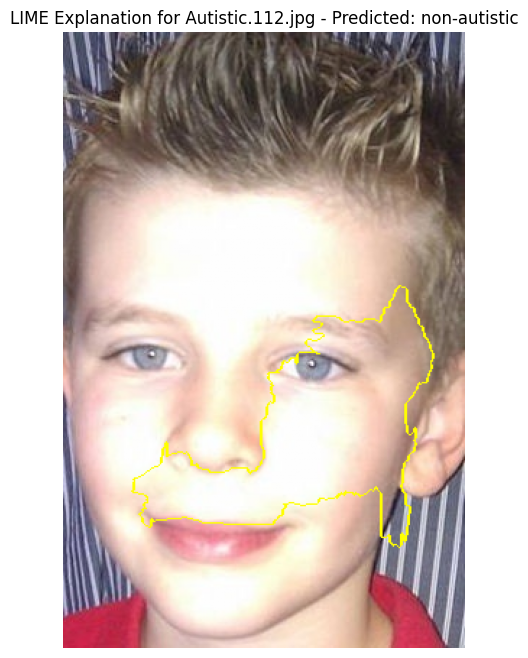

  0%|          | 0/1000 [00:00<?, ?it/s]

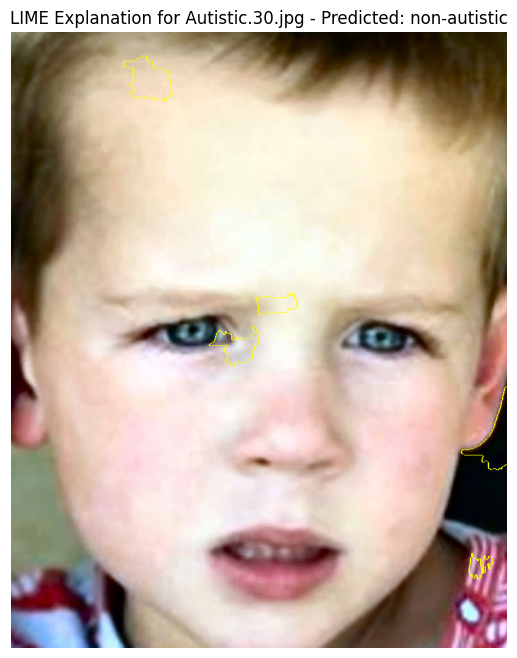

  0%|          | 0/1000 [00:00<?, ?it/s]

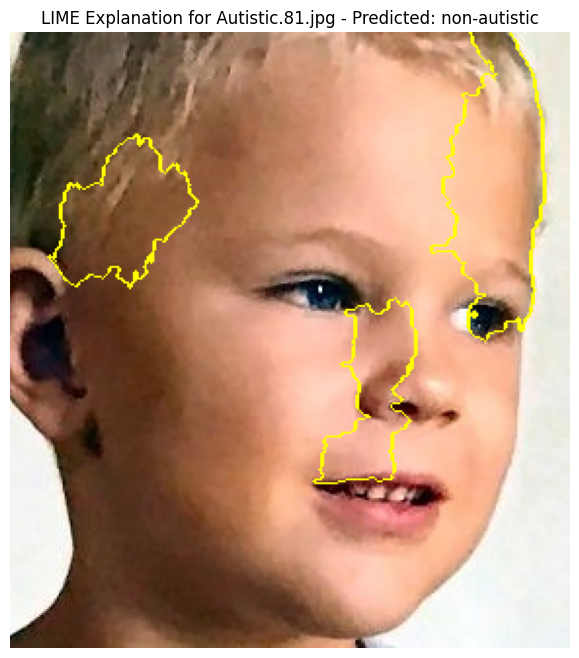

  0%|          | 0/1000 [00:00<?, ?it/s]

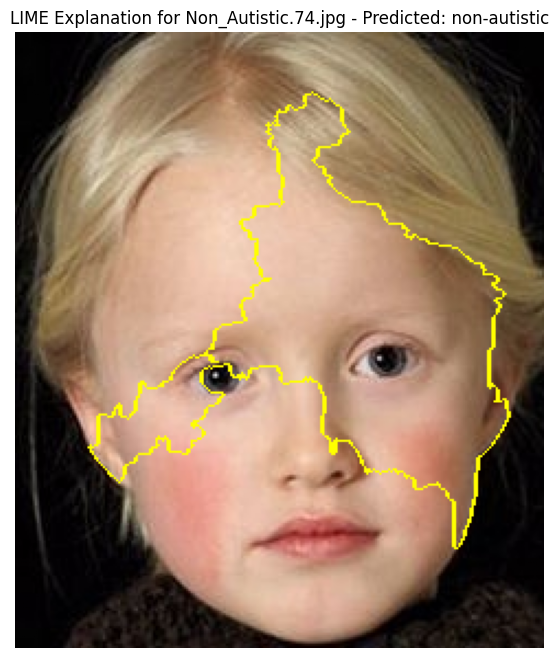

  0%|          | 0/1000 [00:00<?, ?it/s]

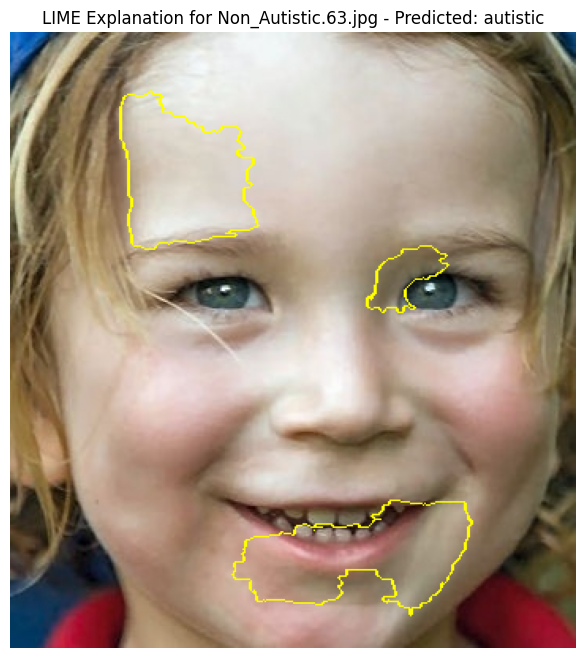

  0%|          | 0/1000 [00:00<?, ?it/s]

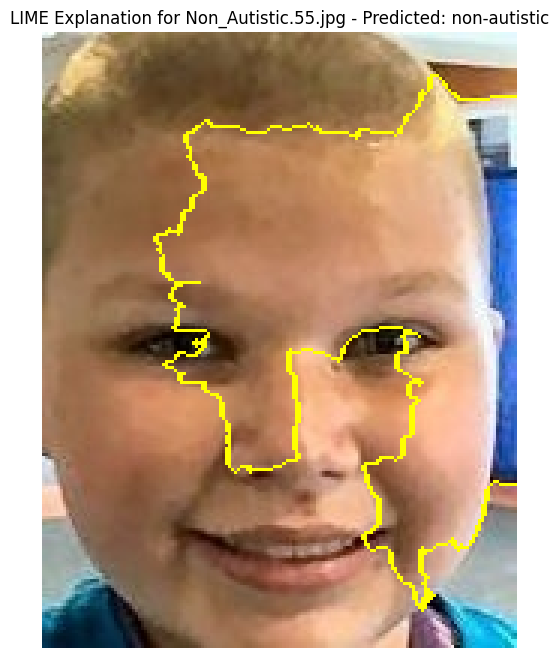

In [12]:
image_dirs = os.path.join(OUTPUT_PATH, "facenet_lime")
os.makedirs(image_dirs, exist_ok=True)

boundary_dir = os.path.join(image_dirs, "boundary")
os.makedirs(boundary_dir, exist_ok=True)

explainer = lime_image.LimeImageExplainer()

for i, img_path in enumerate(selected_image_paths):
    img = Image.open(img_path).convert("RGB")
    image_np = np.array(img)

    explanation = explainer.explain_instance(
        image_np,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000,
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False,
    )

    img_bound = mark_boundaries(temp / 255.0, mask)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_bound)
    plt.title(
        f"LIME Explanation for {os.path.basename(img_path)} - "
        f"Predicted: {idx2label[explanation.top_labels[0]]}"
    )
    plt.axis("off")
    plt.savefig(os.path.join(boundary_dir, f"{i}.png"))
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

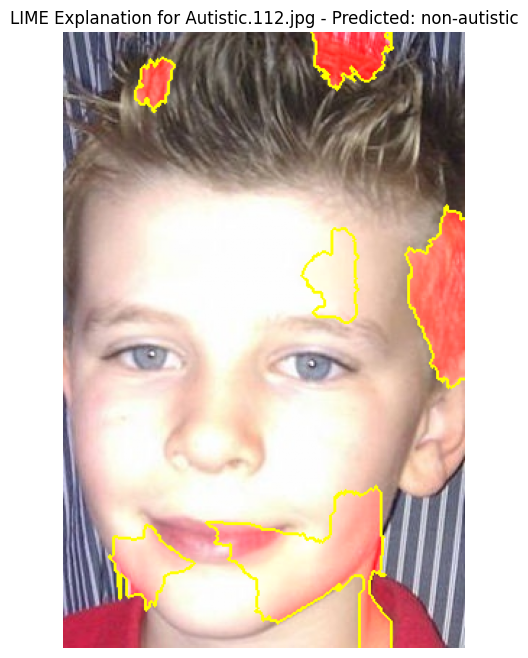

  0%|          | 0/1000 [00:00<?, ?it/s]

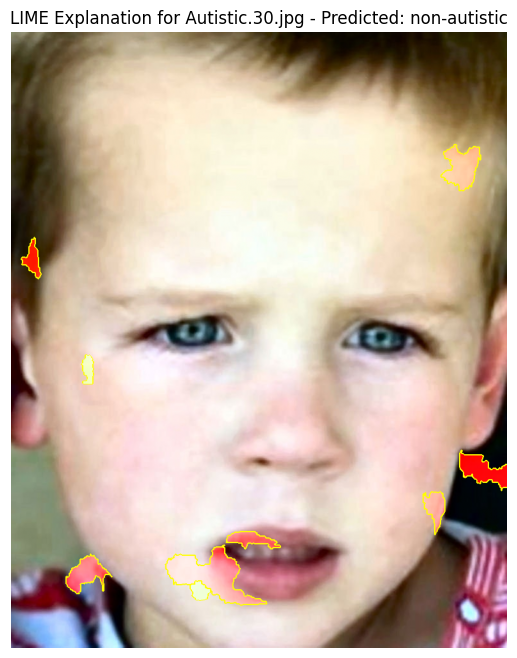

  0%|          | 0/1000 [00:00<?, ?it/s]

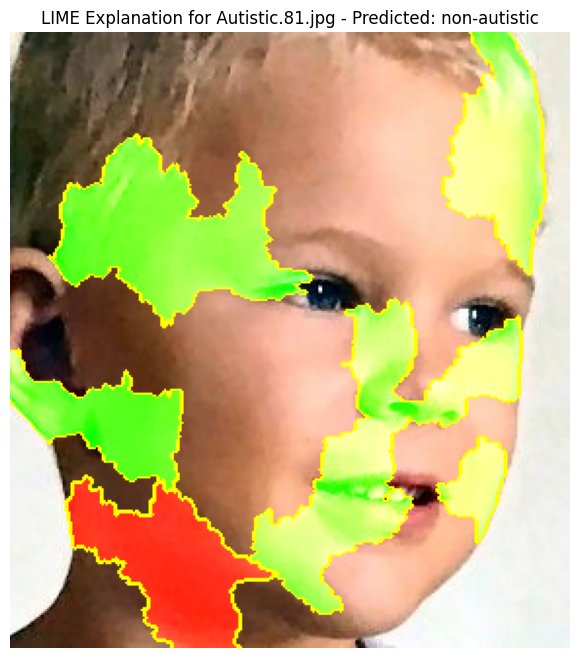

  0%|          | 0/1000 [00:00<?, ?it/s]

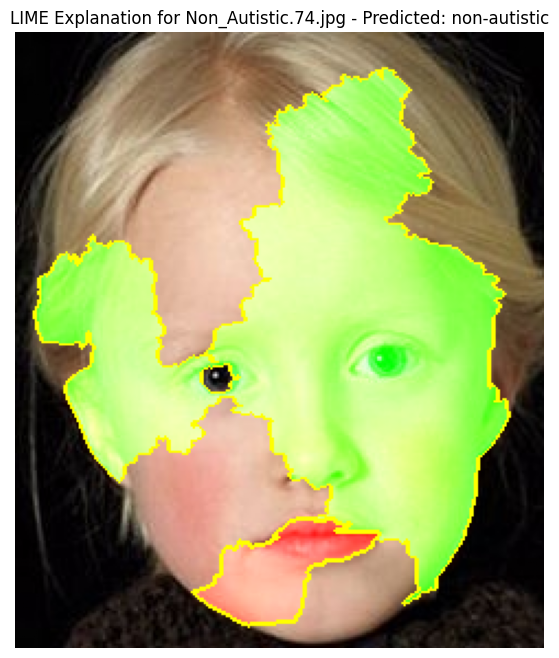

  0%|          | 0/1000 [00:00<?, ?it/s]

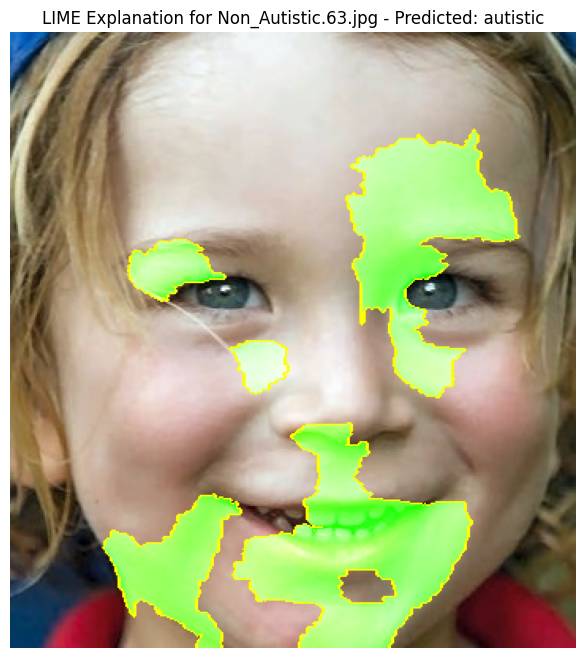

  0%|          | 0/1000 [00:00<?, ?it/s]

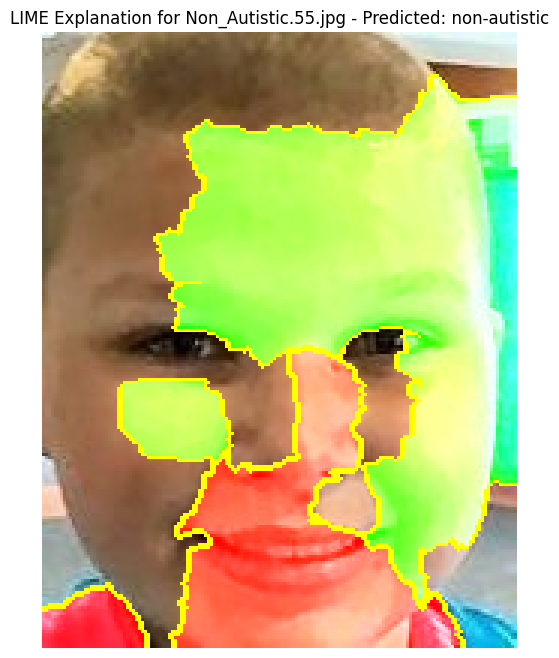

In [13]:
region_dir = os.path.join(image_dirs, "region")
os.makedirs(region_dir, exist_ok=True)

explainer = lime_image.LimeImageExplainer()

for i, img_path in enumerate(selected_image_paths):
    img = Image.open(img_path).convert("RGB")
    image_np = np.array(img)

    explanation = explainer.explain_instance(
        image_np,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000,
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=10,
        hide_rest=False,
    )

    img_bound = mark_boundaries(temp / 255.0, mask)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_bound)
    plt.title(
        f"LIME Explanation for {os.path.basename(img_path)} - "
        f"Predicted: {idx2label[explanation.top_labels[0]]}"
    )
    plt.axis("off")
    plt.savefig(os.path.join(region_dir, f"{i}.png"))
    plt.show()

## SHAP Analysis of FaceNet on ASD Dataset

In [14]:
!pip install shap

In [15]:
import shap

In [16]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.is_sparse:
        x = x.to_dense()
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.is_sparse:
        x = x.to_dense()
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Lambda(lambda x: x * (1 / 255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = transforms.Compose(transform)
inv_transform = transforms.Compose(inv_transform)

In [17]:
# Resize + normalize in predict()
def predict(img: np.ndarray) -> torch.Tensor:
    if img.ndim == 4:  # batch
        img = torch.tensor(img).permute(0, 3, 1, 2)  # NHWC -> NCHW
    elif img.ndim == 3:  # single
        img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)  # HWC -> NCHW
    else:
        raise ValueError(f"Unexpected input shape: {img.shape}")

    img = img.float() / 255.0
    img = transforms.Resize((299, 299))(img)
    img = transforms.Normalize(mean=mean, std=std)(img)
    img = img.to(DEVICE)

    with torch.no_grad():
        output = model(img)

    return output

In [18]:
X = []
for img_path in selected_image_paths:
    img = Image.open(img_path).convert("RGB")
    img = img.resize((160, 160))  # Resize to consistent size for Facenet
    X.append(np.array(img))

X = np.array(X)

print(f"X shape: {X.shape}")

X shape: (6, 160, 160, 3)


In [19]:
topk = 4

batch_size = 50

n_evals = 10000

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(299, 299)", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=idx2label)

2025-10-06 15:00:50.398075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759762850.588509      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759762850.640812      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
# explain how the input creates the output
shap_values = explainer(X, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 1/6 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 3/6 [02:19<01:39, 33.17s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 4/6 [03:25<01:33, 46.89s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 5/6 [04:32<00:54, 54.13s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 6/6 [05:34<00:00, 57.19s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 7it [06:45, 67.56s/it]


In [21]:
# Invert transform for visualization
shap_values.data = inv_transform(torch.tensor(shap_values.data).float() / 255.0).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values, -1, 0)]

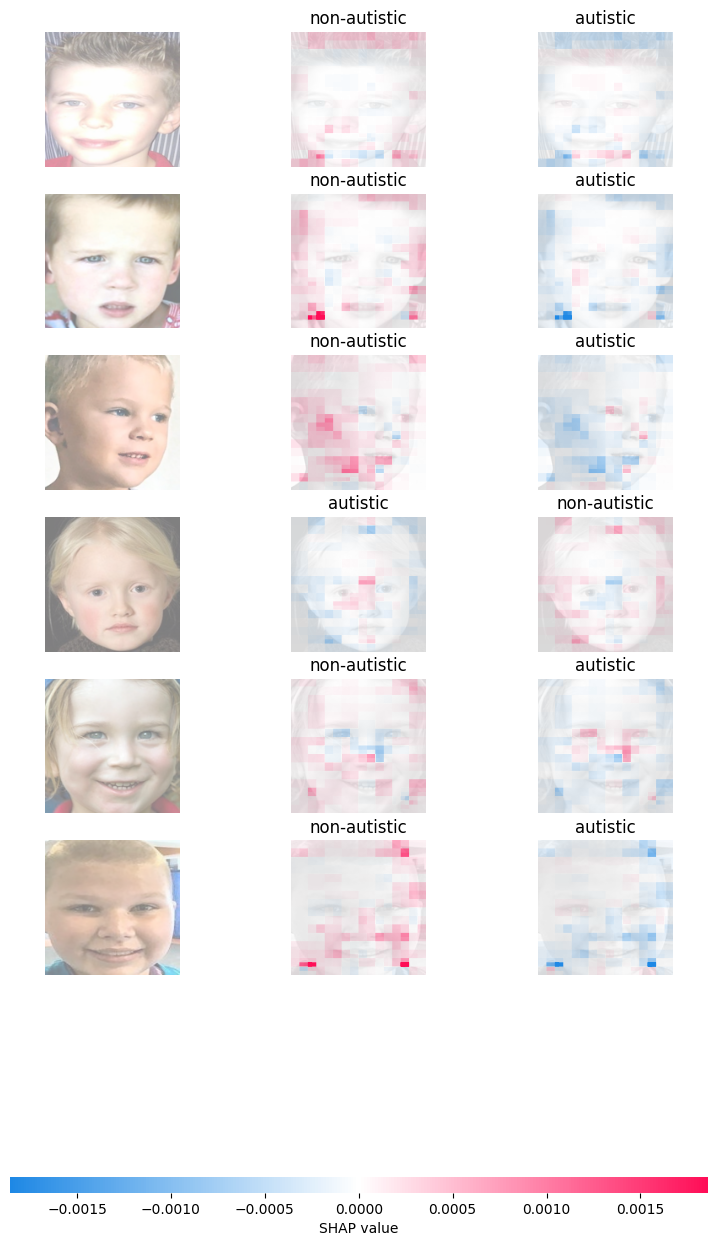

In [22]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
)